# Class for HKStock from MySQL

In [1]:
import pymysql, talib, sys, os, tempfile
import pandas as pd , numpy as np

#############################################
class HKStock:
    conn = None
    symbol=None
    daily=None
    tmpfilename=None
    ####################
    def __init__(self,symbol):
        self.symbol = symbol
        self.populate()
        self.saveCSV()
    ####################
    def populate(self):
        if self.conn is None:
            self.conn = pymysql.connect(host='tptcn.ddns.net', port=53306, db='p_master',
                                   user=os.environ['MYSQL_READUSER'], password=os.environ['MYSQL_READPASSWORD'],
                                   cursorclass=pymysql.cursors.DictCursor)
        tmpl = "SELECT  * FROM `consolidated_daily` WHERE `symbol`='%s' "
        sql = tmpl % (self.symbol)
        self.daily= pd.read_sql(sql, self.conn, index_col=['Date'] )
        ### temp
        sOpen  = self.daily['Open']
        sHigh  = self.daily['High']
        sLow   = self.daily['Low']
        sClose = self.daily['Close']
        sVolume= self.daily['Volume']
    ####################
    def saveCSV(self):
        self.tmpfilename = '/tmp/%s' %(self.symbol)
        self.daily.to_csv(self.tmpfilename, columns=['Open', 'High', 'Low', 'Close', 'Volume'], index_label='Date Time')

    ####################
    def __del__(self):
        if self.conn is not None:
            self.conn.close()
            self.conn = None


# Class for Strategy
## SMA Cross Over

In [2]:
from pyalgotrade import strategy
from pyalgotrade.technical import ma
from pyalgotrade.technical import cross

class SMACrossOver(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, smaPeriod):
        super(SMACrossOver, self).__init__(feed)
        self.__instrument = instrument
        self.__position = None
        # We'll use adjusted close values instead of regular close values.
        #self.setUseAdjustedValues(True)
        self.__prices = feed[instrument].getPriceDataSeries()
        self.__sma = ma.SMA(self.__prices, smaPeriod)

    def getSMA(self):
        return self.__sma

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if cross.cross_above(self.__prices, self.__sma) > 0:
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                # Enter a buy market order. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, shares, True)
        # Check if we have to exit the position.
        elif not self.__position.exitActive() and cross.cross_below(self.__prices, self.__sma) > 0:
            self.__position.exitMarket()


2018-12-25 07:28:39,521 strategy [INFO] Final portfolio value: $946543.08


<IPython.core.display.Javascript object>


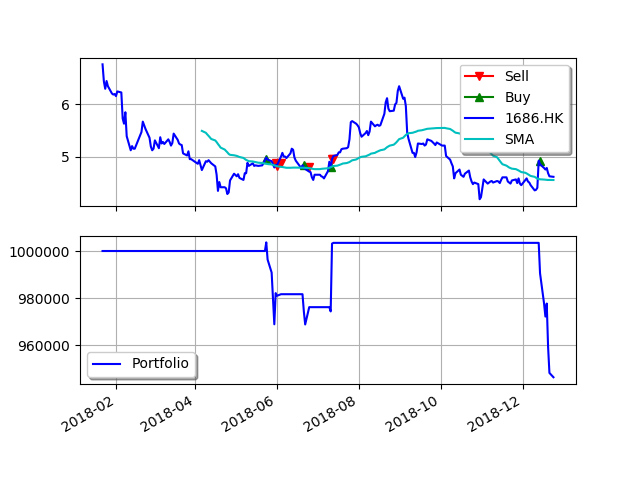

In [3]:
%matplotlib notebook

st = HKStock('1686.HK')
#############################################
from pyalgotrade.barfeed.csvfeed import GenericBarFeed
from pyalgotrade.bar import Frequency

feed = GenericBarFeed(Frequency.DAY,maxLen=20000)
feed.setDateTimeFormat('%Y-%m-%d')
feed.addBarsFromCSV(st.symbol, st.tmpfilename)

#############################################
from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import returns

# Evaluate the strategy with the feed's bars.
myStrategy = SMACrossOver(feed, st.symbol, 50)

# Attach a returns analyzers to the strategy.
returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

# Attach the plotter to the strategy.
plt = plotter.StrategyPlotter(myStrategy)
# Include the SMA in the instrument's subplot to get it displayed along with the closing prices.
plt.getInstrumentSubplot(st.symbol).addDataSeries("SMA", myStrategy.getSMA())
# Plot the simple returns on each bar.
##plt.getOrCreateSubplot("returns").addDataSeries("Simple returns", returnsAnalyzer.getReturns())

# Run the strategy.
myStrategy.run()
myStrategy.info("Final portfolio value: $%.2f" % myStrategy.getResult())

# Plot the strategy.
plt.plot()